Bi-LSTM 추가

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from tensorflow.keras.models import Sequential, load_model, save_model, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from math import sqrt
import os
import pickle
import joblib


# GPU 사용 여부 확인
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)


# 구글드라이브 여부 확인 및 구글 드라이브 설정
import sys
IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

# COLAB에서 사용하는 경우 default 경로 지정
if IS_COLAB:
    DEFAULT_PATH = "/content/drive/My Drive/Colab Notebooks/"
else:
    DEFAULT_PATH = ''

#############################################################################
# pickle 오류 대응
# https://github.com/tensorflow/tensorflow/issues/34697
from tensorflow.python.keras.saving import saving_utils
from tensorflow.python.keras.layers import deserialize, serialize

def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

## Hotfix function
def make_keras_picklable():

    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

    cls = Model
    cls.__reduce__ = __reduce__

## Run the function
make_keras_picklable()
#############################################################################

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6531909934125780575
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6479912273014171981
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
2.6.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Mounted at /content/drive


In [ ]:
def pr_weather(ds, week=False):
    """
    기상 데이터 전처리

    생육 적정 온도에서 벗어나는 값, 
    발아 한계 기온에서 벗어나는 값, 
    태풍 여부 등을 처리함
    """
    weather = ds.copy()
    weather["관측시각"] = pd.to_datetime(weather["관측시각"], format="%Y-%m-%d")
    weather.drop(columns=["연도", "월", "일"], inplace=True)
    weather.sort_values("관측시각", inplace=True)
    
    # 생육 적정온도 15 ~ 25도
    # 최적기온을 벗어나는 값을 최저기온, 평균기온, 최고기온에 따라
    # 가중치 값을 달리함
    weather["!최적기온"] = 0 
    temp_index = \
        weather[
            (weather["최저기온"] < 15)
            | (weather["최고기온"] > 25)
        ].index
    weather.loc[temp_index, "!최적기온"] += 1

    temp_index = \
        weather[
            (weather["기온"] < 15)
            | (weather["기온"] > 25)
        ].index
    weather.loc[temp_index, "!최적기온"] += 5

    temp_index = \
        weather[
            (weather["최고기온"] < 15)
            | (weather["최저기온"] > 25)
        ].index
    weather.loc[temp_index, "!최적기온"] += 10

    # 발아 한계 기온
    # 발아 한계 기온에서 벗어나는 값을 최저기온, 평균기온, 최고기온에 따라
    # 가중치 값을 달리함
    weather["불량기온"] = 0 
    temp_index = \
        weather[
            (weather["최저기온"] < 0)
            | (weather["최고기온"] > 33)
        ].index
    weather.loc[temp_index, "불량기온"] += 1

    temp_index = \
        weather[
            (weather["기온"] < 0)
            | (weather["기온"] > 33)
        ].index
    weather.loc[temp_index, "불량기온"] += 5

    temp_index = \
        weather[
            (weather["최고기온"] < 0)
            | (weather["최저기온"] > 33)
        ].index
    weather.loc[temp_index, "불량기온"] += 10

    # 강수량이 90을 초과하고 풍속이 4 이상이면 태풍이라고 판단함
    weather["태풍"] = 0
    weather.loc[
        (weather["강수량"] > 90) & (weather["풍속"] > 4),
        "태풍"
    ] = 1    

    agg_dict = {
        "기온": [("기온", "mean")],
#         "최고기온": [("최고기온", "max")],
#         "최저기온": [("최저기온", "min")],
#         "습도": [("습도", "mean")],
#         "풍속": [("풍속", "mean")],
        "일조시간": [("일조시간", "sum")],
        "일사량": [("일사량", "sum")],
        "결로시간": [("결로시간", "sum")],
        "!최적기온": [("!최적기온", "sum")],
        "불량기온": [("불량기온", "sum")],
        "태풍": [("태풍", "sum")],
    }
    
    if week:
        # 연도와 주번호 생성
        weather["WEEK_N"] = weather["관측시각"].dt.strftime('%U')
        weather["YEAR"] = weather["관측시각"].dt.year
        weather_g = \
            weather.groupby(["관측지점명", "YEAR", "WEEK_N"]).agg(agg_dict)
    else:
        weather_g = \
            weather.groupby(["관측지점명", "관측시각"]).agg(agg_dict)
    weather_g.reset_index(col_level=1, inplace=True)
    weather_g = weather_g.droplevel(level=0, axis=1)
    
    # 지역명 변경
    loca_dict = {
        "진도군 군내면": "전라남도(진도+)",
        "부산시 강서구": "경상남도(부산+)",
        "평창군 여만리": "강원도(평창+)",
        "남양주 진건읍": "경기도(구리+)"
    }

    for loc in loca_dict.keys():
        weather_g.loc[weather_g["관측지점명"] == loc, "관측지점명"] = loca_dict[loc]

    return weather_g

In [ ]:
def pr_main(ds, drop_leap_year=True):
    """
    기본적인 데이터 처리

    drop_leap_year=True: 윤년(leap year) 2월 29일 데이터 삭제
    """
    main = ds.copy()
    
    main["DELNG_DE"] = pd.to_datetime(main["DELNG_DE"], format="%Y%m%d")
    drop_columns = \
        [
         "PBLMNG_WHSAL_MRKT_NM", "CPR_NM", 
         "DELNGBUNDLE_QY", "STNDRD", "DELNG_QY"
        ]
    main.drop(columns=drop_columns, inplace=True)
    main.reset_index(drop=True, inplace=True)

    # 윤년(leap year) 2월 29일 삭제
    if drop_leap_year:
        drop_index = \
            main.loc[
                (main["DELNG_DE"].dt.month == 2)
                & (main["DELNG_DE"].dt.day == 29)
            ].index
        main.drop(drop_index, inplace=True)
    else:
        pass
    
    return main

# 메인 데이터 일별 그룹화
def main_to_day(ds):
    main = ds.copy()
    def q80(x):
        return x.quantile(0.8)
    def q20(x):
        return x.quantile(0.2)

    # 월 더미 추가
    month_dumm = pd.get_dummies(main["DELNG_DE"].dt.month_name())
    main = pd.concat([main, month_dumm], axis=1)

    agg_dict = {
        "PRICE": [
            # ("P_MIN", "min"),
            # ("P_MAX", "max"),
            ("P_MEDIAN", np.median),
            ("P_MEAN", np.mean),
            ("P_STD", np.std),
            ("P_Q80", q80),
            ("P_Q20", q20),
        ],
        "VOLUME": [
            ("VOLUME", "sum"),
        ],
        "January": [("January", "mean")],
        "February": [("February", "mean")],
        "March": [("March", "mean")],
        "April": [("April", "mean")],
        "May": [("May", "mean")],
        "June": [("June", "mean")],
        "July": [("July", "mean")],
        "August": [("August", "mean")],
        "September": [("September", "mean")],
        "October": [("October", "mean")],
        "November": [("November", "mean")],
        "December": [("December", "mean")]
    }

    main_g = main.groupby(["SANJI_NM", "DELNG_DE"]).agg(agg_dict).copy()
    main_g.reset_index(col_level=1, inplace=True)
    main_g = main_g.droplevel(level=0, axis=1)

    # 표준편차 결측값 0으로 대치
    main_g["P_STD"].fillna(0, inplace=True)
    
    # # weekday 추가
    # weekday_dumm = pd.get_dummies(main_g["DELNG_DE"].dt.weekday)
    # weekday_dumm.columns = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
    # main_g = pd.concat([main_g, weekday_dumm], axis=1)

    # # 주번호(일요일 기준) 추가
    # main_g["WEEK_N"] = main_g["DELNG_DE"].dt.strftime('%U')

    # # 연 추가
    # main_g["YEAR"] = main_g["DELNG_DE"].dt.year

    # 이동평균
    main_g["P_MEDIAN"].rolling(5, min_periods=1).mean()

    # 중앙가격 지수이동평균 (Exponetial Moving Average)
    main_g["P_EMA5"] = main_g["P_MEDIAN"].ewm(5, min_periods=1).mean()
    main_g["P_EMA20"] = main_g["P_MEDIAN"].ewm(20, min_periods=1).mean()
    main_g["P_EMA45"] = main_g["P_MEDIAN"].ewm(45, min_periods=1).mean()
    main_g["P_EMA60"] = main_g["P_MEDIAN"].ewm(60, min_periods=1).mean()
    main_g["P_EMA90"] = main_g["P_MEDIAN"].ewm(90, min_periods=1).mean()

    # 거래량 지수이동평균 (Exponetial Moving Average)
    main_g["V_EMA5"] = main_g["VOLUME"].ewm(5, min_periods=1).mean()
    main_g["V_EMA20"] = main_g["VOLUME"].ewm(20, min_periods=1).mean()
    main_g["V_EMA45"] = main_g["VOLUME"].ewm(45, min_periods=1).mean()
    main_g["V_EMA60"] = main_g["VOLUME"].ewm(60, min_periods=1).mean()
    main_g["V_EMA90"] = main_g["VOLUME"].ewm(90, min_periods=1).mean()
    
    return main_g

# 메인 데이터 주별 그룹화
def main_to_week(ds):
    main = ds.copy()
    
    main.sort_values("DELNG_DE", inplace=True)
    # 주번호(일요일 기준)
    main["WEEK_N"] = main["DELNG_DE"].dt.strftime('%U')
    # 연도
    main["YEAR"] = main["DELNG_DE"].dt.year
    
    # 월 더미 추가
    month_dumm = pd.get_dummies(main["DELNG_DE"].dt.month_name())
    main = pd.concat([main, month_dumm], axis=1)

    # 그룹화
    def q80(x):
        return x.quantile(0.8)
    def q20(x):
        return x.quantile(0.2)

    agg_dict = {
        "PRICE": [
            # ("P_MIN", "min"),
            # ("P_MAX", "max"),
            ("P_MEDIAN", np.median),
            ("P_MEAN", np.mean),
            ("P_STD", np.std),
            ("P_Q80", q80),
            ("P_Q20", q20),
        ],
        "VOLUME": [
            ("VOLUME", "sum"),
            ("V_STD", np.std)
        ],
        "January": [("January", "mean")],
        "February": [("February", "mean")],
        "March": [("March", "mean")],
        "April": [("April", "mean")],
        "May": [("May", "mean")],
        "June": [("June", "mean")],
        "July": [("July", "mean")],
        "August": [("August", "mean")],
        "September": [("September", "mean")],
        "October": [("October", "mean")],
        "November": [("November", "mean")],
        "December": [("December", "mean")]
    }
    main_g = main.groupby(["SANJI_NM", "YEAR", "WEEK_N"]).agg(agg_dict).copy()
    main_g.reset_index(col_level=1, inplace=True)
    main_g = main_g.droplevel(level=0, axis=1)

    # 표준편차 결측값 0으로 대치
    main_g["P_STD"].fillna(0, inplace=True)
    
    # 가격 중앙값 이동평균 
    main_g["P_EMA5"] = main_g["P_MEDIAN"].ewm(5, min_periods=1).mean()
    main_g["P_EMA15"] = main_g["P_MEDIAN"].ewm(15, min_periods=1).mean()
    main_g["P_EMA30"] = main_g["P_MEDIAN"].ewm(30, min_periods=1).mean()
    
    # 거래량 이동평균
    main_g["V_EMA5"] = main_g["VOLUME"].ewm(5, min_periods=1).mean()
    main_g["V_EMA15"] = main_g["VOLUME"].ewm(15, min_periods=1).mean()
    main_g["V_EMA30"] = main_g["VOLUME"].ewm(30, min_periods=1).mean()
    
    return main_g

In [ ]:
def mmscale_loc(ds, target):
    """
    target(y)과 x features를 나눠서 scale 하고,
    scaler 모델을 저장한 후 반환함
    """
    data = ds.copy()
    data.reset_index(drop=True, inplace=True)
    mmscaler_x = MinMaxScaler()
    mmscaler_y = MinMaxScaler()

    # feature drop list
    drop_list = [target]
    if "SANJI_NM" in data.columns:
        drop_list.append("SANJI_NM")
    if "DELNG_DE" in data.columns:
        drop_list.append("DELNG_DE")

    # 변환할 컬럼 집합
    scale_list = data.columns.drop(drop_list)
    mmscaler_x = mmscaler_x.fit(data[scale_list])
    mm_scaled_x = mmscaler_x.transform(data[scale_list])

    mmscaler_y = mmscaler_y.fit(data[[target]])
    mm_scaled_y = mmscaler_y.transform(data[[target]])

    # 스케일된 값 to DataFrame
    x_df = pd.DataFrame(mm_scaled_x, columns=scale_list)
    y_df = pd.DataFrame(mm_scaled_y, columns=[target])

    data_scaled = pd.concat([x_df, y_df] ,axis=1)

    # 모델 저장
    folder_path = FOLDER_PATH + "Model/"
    x_path = f"{folder_path}[MMS_X]{DEFAULT_FILE_NAME}"
    joblib.dump(mmscaler_x, f"{x_path}.pkl")
    y_path = f"{folder_path}[MMS_Y]{DEFAULT_FILE_NAME}"
    joblib.dump(mmscaler_y, f"{y_path}.pkl")

    return (data_scaled, mmscaler_x, mmscaler_y)

In [ ]:
def change_datasets(ds, target, window_size=1, future_size=1):
    """
    시계열 데이터로 새롭게 만들어진 데이터를
    target과 train datasets으로 나누어 반환함
    """
    datasets = ds.copy()

    # 시계열 데이터 셋 생성 함수
    def make_seq_dataset(x, y, window_size, future_size):
        data = x.copy()
        label = y.copy()
        feature_list = []
        label_list = []
        # window_size 일간의 데이터 집합과 미래 future_size 후의 target 데이터로 나눔
        for i in range(len(data) - window_size - future_size + 1):
            # window_size 만틈의 데이터 집합
            feature_list.append(
                np.array(data.iloc[i:i+window_size])
            )
            # 미래 futre_size 후의 target 데이터
            label_list.append(
                np.array(label.iloc[i+window_size + future_size - 1])
            )
    
        return np.array(feature_list), np.array(label_list)

    # 시계열에 따라 나눠진 데이터를 target과 train datasets으로 나눔
    x_col = datasets.columns.drop(target)
    y_col = [target]

    ds_x = datasets[x_col]
    ds_y = datasets[y_col]

    new_ds_x, new_ds_y = \
        make_seq_dataset(ds_x, ds_y, window_size, future_size)

    return (new_ds_x, new_ds_y)

In [ ]:
def user_lstm(
            train_ds, 
            location,
            #loss="mean_absolute_percentage_error",
            loss="mse",
            dropout=[0]
        ):
    """
    loss = ["mean_absolute_percentage_error", "mean_absolute_error", ...]
    https://www.tensorflow.org/api_docs/python/tf/keras/losses
    """
    train = train_ds.copy()

    train_x, train_y = \
        change_datasets(train, TARGET, WINDOW_SIZE, FUTURE_SIZE)

    x_train, x_valid, y_train, y_valid = \
        train_test_split(train_x, train_y, test_size=0.2) #random_state=2021)
        # TODO: random_state 나중에 빼기

    # UNIT과 ACTIVE, DROPOUT 원소의 개수를 같게 줘야 함
    unit_list = UNIT
    active_list = ACTIVE
    dropout_list = dropout
    if not (len(unit_list) == len(active_list) == len(dropout_list)):
        # 같지 않으면 마지막 값을 가장 큰 개수만큼 추가함
        uad_len = [len(unit_list), len(active_list), len(dropout_list)]
        max_len = max(uad_len)
        uad_append_len = max_len - np.array(uad_len)
        for i, append_n in enumerate(uad_append_len):
            if append_n != 0:
                if i == 0:
                    for _ in range(append_n):
                        unit_list.append(unit_list[uad_len[i] - 1])
                elif i == 1:
                    for _ in range(append_n):
                        active_list.append(active_list[uad_len[i] - 1])
                elif i == 2:
                    for _ in range(append_n):
                        dropout_list.append(dropout_list[uad_len[i] - 1])
    else:
        max_len = len(unit_list)

    model = Sequential()

    # UNIT과 ACTIVE, DROPOUT, DENSE 중 가장 원소가 많은 수만큼 모델을 add함
    for i in range(max_len):
        # 마지막 반복이면 return_sequences는 False
        if i == (max_len - 1):
            return_sequences=False
        else:
            return_sequences=True

        model.add(Bidirectional(LSTM(
                unit_list[i],
                input_shape=(train_x.shape[1], train_x.shape[2]),
                activation=active_list[i],
                return_sequences=return_sequences,
            )
        ))
        model.add(Dropout(dropout_list[i]))

    model.add(Dense(1)) # Dense(Target 개수(종류))
    
    # 컴파일
    model.compile(loss=loss, optimizer="adam")

    # 조기 중단 설정
    ealry_stop = \
        EarlyStopping(
            monitor="val_loss", 
            patience=EARLYSTOPPOING # n개 이상 개선되지 않으면 중단
        )

    # 저장 관련 설정
    folder_path = FOLDER_PATH + "Model/"
    file_name = f"[FINAL_BI_LSTM_U16_DROP]{location}_{DEFAULT_FILE_NAME}"
    model_save_path = f"{folder_path}{file_name}"
    
    # 최적의 모델이 나올때마다 덮어쓰면서 저장됨
    checkpoint = \
        ModelCheckpoint(
            f"{model_save_path}.h5",
            monitor="val_loss",
            verbose=1, # 0, 1
            save_best_only=True, # 최적값일 때만 덮어씀(저장)
            # save_weights_only=True, # weights만 저장, 전체 저장x
            mode="auto" # {max,min,auto}
        )

    history = \
        model.fit(
            x_train, y_train,
            epochs=EPOCH,
            batch_size=BATCH,
            validation_data=(x_valid, y_valid),
            callbacks=[ealry_stop, checkpoint]
    )

    # save_model(model, f"{model_save_path}.h5")
    # pickle로 모델 저장    
    with open(f"{model_save_path}.pkl", "wb") as f:
        pickle.dump(model,f)

    evaluate = model.evaluate(x_valid, y_valid)

    return model, history, evaluate, file_name

In [ ]:
def user_lstm_kfolded(
                    train_ds, 
                    location,
                    fold=5,
                    loss="mean_absolute_percentage_error",
                    dropout=[0]
                ):
    """
    loss = ["mean_absolute_percentage_error", "mean_absolute_error", ...]
    https://www.tensorflow.org/api_docs/python/tf/keras/losses
    """
    train = train_ds.copy()
    
    # 각 fold별 평가값이 저장될 리스트 생성
    evaluate = []

    train_x, train_y = \
        change_datasets(train, TARGET, WINDOW_SIZE, FUTURE_SIZE)

    kf = KFold(n_splits=fold)

    # UNIT과 ACTIVE, DROPOUT 원소의 개수를 같게 줘야 함
    unit_list = UNIT
    active_list = ACTIVE
    dropout_list = dropout
    if not (len(unit_list) == len(active_list) == len(dropout_list)):
        # 같지 않으면 마지막 값을 가장 큰 개수만큼 추가함
        uad_len = [len(unit_list), len(active_list), len(dropout_list)]
        max_len = max(uad_len)
        print(max_len)
        uad_append_len = max_len - np.array(uad_len)
        for i, append_n in enumerate(uad_append_len):
            if append_n != 0:
                if i == 0:
                    for _ in range(append_n):
                        unit_list.append(unit_list[uad_len[i] - 1])
                elif i == 1:
                    for _ in range(append_n):
                        active_list.append(active_list[uad_len[i] - 1])
                elif i == 2:
                    for _ in range(append_n):
                        dropout_list.append(dropout_list[uad_len[i] - 1])
    else:
        max_len = len(unit_list)


    # KFOLD 만큼 반복함
    kn = 0
    for train_i, valid_i in kf.split(train_x, train_y):    
        model = Sequential()
        kn += 1
        # UNIT과 ACTIVE, DROPOUT, DENSE 중 가장 원소가 많은 수만큼 모델을 add함
        for i in range(max_len):
            # 마지막 반복이면 return_sequences는 False
            if i == (max_len - 1):
                return_sequences=False
            else:
                return_sequences=True

            model.add(
                LSTM(
                    unit_list[i],
                    input_shape=(train_x.shape[1], train_x.shape[2]),
                    activation=active_list[i],
                    return_sequences=return_sequences,
                )
            )
            model.add(Dropout(dropout[i]))

        model.add(Dense(1)) # Dense(Target 개수(종류))
    
        # 컴파일
        model.compile(loss=loss, optimizer="adam")

        # 조기 중단 설정
        ealry_stop = \
            EarlyStopping(
                monitor="val_loss", 
                patience=EARLYSTOPPOING # n개 이상 개선되지 않으면 중단
            )

        # 저장 관련 설정
        folder_path = FOLDER_PATH + "Model/"
        file_name = f"[BI_LSTM_U16]{location}_{DEFAULT_FILE_NAME}_{kn}"
        model_save_path = f"{folder_path}{file_name}"
        
        # 최적의 모델이 나올때마다 덮어쓰면서 저장됨
        checkpoint = \
            ModelCheckpoint(
                f"{model_save_path}.h5",
                monitor="val_loss",
                verbose=1, # 0, 1
                save_best_only=True, # 최적값일 때만 덮어씀(저장)
                # save_weights_only=True, # weights만 저장, 전체 저장x
                mode="auto" # {max,min,auto}
            )

        # valid 데이터셋 지정
        valid_x = train_x[valid_i]
        valid_y = train_y[valid_i]

        history = \
            model.fit(
                train_x[train_i], train_y[train_i],
                epochs=EPOCH,
                batch_size=BATCH,
                validation_data=(valid_x, valid_y),
                callbacks=[ealry_stop, checkpoint]
        )
        evaluate.append(model.evaluate(valid_x, valid_y))

    # 모델 저장
    save_model(model, f"{model_save_path}_f.h5")
    # pickle로 모델 저장    
    with open(f"{model_save_path}.pkl", "wb") as f:
        pickle.dump(model,f)

    return model, history, evaluate, file_name

In [ ]:
def res_print(loc, path, model, x,y, mms_y, evaluate):

    # RMSE
    def rmse(actual, pred):
        return sqrt(mean_squared_error(actual, pred))

    # MAPE
    def mape(actual, pred):
        return np.mean(np.abs((actual - pred) / actual)) * 100

    model.load_weights(f"{FOLDER_PATH}Model/{path}.h5")
    pred = mms_y.inverse_transform(model.predict(x)).reshape(-1)
    actual = mms_y.inverse_transform(y).reshape(-1)

    pred_before_inv = model.predict(x).reshape(-1)
    actual_before_inv = y.reshape(-1)

    if pred.shape != actual.shape:
        print("Prediction shape ERROR")

    rmse_raw = format(rmse(actual, pred), '20.5f')
    rmse_scal = format(rmse(pred_before_inv, actual_before_inv), '20.5f')
    mape = format(mape(actual, pred), '20.5f')
    evaluate = format(evaluate, '20.5f')

    text = (
        f"""{'+' * 69}\n"""
        f"""location      = {loc}\n"""
        f"""week          = {WEEK}\n"""
        f"""target        = {TARGET}\n"""
        f"""future_size   = {FUTURE_SIZE}\n"""
        f"""window_size   = {WINDOW_SIZE}\n"""
        f"""test_size     = {TEST_SIZE}\n"""
        f"""unit          = {UNIT}\n"""
        f"""active        = {ACTIVE}\n"""
        f"""epoch         = {EPOCH}\n"""
        f"""batch         = {BATCH}\n"""
        f"""early stop    = {EARLYSTOPPOING}\n"""
        f"""dropout       = {DROPOUT}\n"""
        f"""model path    = {FOLDER_PATH}Model/{path}\n"""
        f"""{'+' * 69}\n"""
        f"""rmse(raw)     = {rmse_raw}\n"""
        f"""rmse(scaled)  = {rmse_scal}\n"""
        f"""MAPE          = {mape}\n"""
        f"""evaluate      = {evaluate}\n"""
        f"""{'+' * 69}\n"""
    )


    # 출력 결과 텍스트 파일로 저장
    folder_path = FOLDER_PATH + "Result/"
    res_save_path = f"{folder_path}[FINAL_BI_LSTM_U16_R]{DEFAULT_FILE_NAME}.txt"

    f = open(res_save_path, 'a')
    print(text, file=f)
    f.close()
    
    # summary 저장
    # https://pythonq.com/so/python/271129
    from contextlib import redirect_stdout
    with open(res_save_path, 'a') as f:
        with redirect_stdout(f):
            model.summary()

    # 지역별 파일에 누적해서 결과 저장
    res_save_path2 = f"{folder_path}[{loc}]result_log.txt"
    f2 = open(res_save_path2, 'a')
    print(text, file=f2)
    f2.close()
    
    # summary 저장
    # https://pythonq.com/so/python/271129
    from contextlib import redirect_stdout
    with open(res_save_path2, 'a') as f2:
        with redirect_stdout(f2):
            model.summary()

In [ ]:
def graph_loss(loc, history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    sns.set_theme(
        style="whitegrid",
        font="AppleGothic", 
        rc={"axes.unicode_minus": False},
    )

    plt.figure(figsize=(20, 10))
    plt.plot(
        loss,
        label="Train",
        color="navy",
        # alpha=0.6,
    )
    plt.plot(
        val_loss,
        label="Valid",
        color="darkgreen",
        # alpha=0.6,
    )

    # WEEK이면 W, DAY이면 D
    date = 'W' if WEEK else 'D'

    plt.title(
        f"{loc} MODEL LOSS({TARGET}, {date}+{FUTURE_SIZE})",
        pad=20,
        fontsize=20,
        fontweight="heavy",
        color="gray",
    )

    plt.ylabel(
        "LOSS",
        fontsize=15,
        fontweight="bold",
        color="gray",
    )
    plt.xlabel(
        "EPOCH",
        fontsize=15,
        fontweight="bold",
        color="gray",
    )
    plt.xticks(
        color="gray",
    )
    plt.yticks(
        color="gray",
    )
    plt.legend(
        loc="upper left",
        fontsize=15,
        framealpha=0, # 배경색 투명도
        ncol=2,
    )
    plt.grid(
        True,
        axis='y',
        color='lightgray',
        # alpha=0.8
    )
    plt.fill_between(
        range(len(loss)), 
        loss, 
        val_loss, 
        color="lightpink", 
        alpha=0.3,
    )
    plt.savefig(
        f"{FOLDER_PATH}Graph/[G][loss][{loc}]{DEFAULT_FILE_NAME}.png",
        transparent = True, # 배경색 투명하게
        dpi=150, # 해상도
    )
    # plt.show()

In [ ]:
def graph_predict(loc, model_path, model, x, y, mms_y):
    model.load_weights(model_path)

    # shape를 1D로 변환 후 inverse mmscale
    pred = mms_y.inverse_transform(model.predict(x)).reshape(-1)
    actual = mms_y.inverse_transform(y).reshape(-1)

    # actual_pred_diff = actual - pred
    # plus_diff_i = np.where(actual_pred_diff >= 0)[0]
    # minus_diff_i = np.where(actual_pred_diff < 0)[0]

    plt.figure(figsize=(20, 10))
    plt.plot(
        actual,
        label="actual",
        color="navy",
        # alpha=0.6,
    )
    plt.plot(
        pred,
        label="Predict",
        color="darkgreen",
        # alpha=0.6,
    )

    # WEEK이면 W, DAY이면 D
    date = 'W' if WEEK else 'D'

    plt.title(
        f"{loc} FINAL_BI_LSTM Prediction({TARGET}, {date}+{FUTURE_SIZE})",
        pad=20,
        fontsize=20,
        fontweight="heavy",
        color="gray",
    )
    plt.ylabel(
        TARGET,
        fontsize=15,
        fontweight="bold",
        color="gray",
    )
    plt.xlabel(
        "WEEK",
        fontsize=15,
        fontweight="bold",
        color="gray",
    )
    plt.yticks(
        color="gray",
    )
    plt.xticks(
        color="gray",
    )
    plt.legend(
        loc="upper left",
        fontsize=15,
        framealpha=0, # 배경색 투명도
        ncol=2,
    )
    plt.grid(
        True,
        axis='y',
        color='lightgray',
        # alpha=0.8
    )
    plt.fill_between(
        range(len(actual)), 
        pred, 
        actual, 
        color="lightpink", 
        alpha=0.3
    )
    plt.savefig(
        f"{FOLDER_PATH}Graph/[G][predict][{loc}]{DEFAULT_FILE_NAME}.png",
        transparent = True, # 배경색 투명하게
        dpi=150, # 해상도
    )
    # plt.show()

In [ ]:
def graph_train(loc, train_ds, model_path, model, mms_y):
    """
    실제 값 예측 그래프
    """
    train_x, train_y = \
        change_datasets(train_ds, TARGET, WINDOW_SIZE, FUTURE_SIZE)

    model.load_weights(model_path)
    # shape를 1D로 변환 후 inverse mmscale
    pred = mms_y.inverse_transform(model.predict(train_x)).reshape(-1)
    actual = mms_y.inverse_transform(train_y).reshape(-1)

    plt.figure(figsize=(20, 10))
    plt.plot(
        actual,
        label="actual",
        color="navy",
        # alpha=0.6,
    )
    plt.plot(
        pred,
        label="Predict",
        color="darkgreen",
        # alpha=0.6,
    )

    # WEEK이면 W, DAY이면 D
    date = 'W' if WEEK else 'D'

    plt.title(
        f"{loc} BI_LSTM Train({TARGET}, {date}+{FUTURE_SIZE})",
        pad=20,
        fontsize=20,
        fontweight="heavy",
        color="gray",
    )
    plt.ylabel(
        TARGET,
        fontsize=15,
        fontweight="bold",
        color="gray",
    )
    plt.xlabel(
        "WEEK",
        fontsize=15,
        fontweight="bold",
        color="gray",
    )
    plt.yticks(
        color="gray",
    )
    plt.xticks(
        color="gray",
    )
    plt.legend(
        loc="upper left",
        fontsize=15,
        framealpha=0, # 배경색 투명도
        ncol=2,
    )
    plt.grid(
        True,
        axis='y',
        color='lightgray',
        # alpha=0.8
    )
    plt.fill_between(
        range(len(actual)), 
        pred, 
        actual, 
        color="lightpink", 
        alpha=0.3
    )
    plt.savefig(
        f"{FOLDER_PATH}Graph/[G][train][{loc}]{DEFAULT_FILE_NAME}.png",
        transparent = True, # 배경색 투명하게
        dpi=150, # 해상도
    )
    # plt.show()

In [ ]:
def graph_finished(loc, scaled_ds, train_ds, model_path, model, mms_y,path):
    """
    실제 및 예측 그래프
    """
    train_x, train_y = \
        change_datasets(scaled_ds, TARGET, WINDOW_SIZE, FUTURE_SIZE)

    model.load_weights(model_path)
    # shape를 1D로 변환 후 inverse mmscale
    pred = mms_y.inverse_transform(model.predict(train_x)).reshape(-1)
    actual = mms_y.inverse_transform(train_y).reshape(-1)

    plt.figure(figsize=(20, 10))
    plt.plot(
        actual,
        label="actual",
        color="navy",
    )
    plt.plot(
        pred,
        label="Predict",
        color='darkgreen',
    )

    # WEEK이면 W, DAY이면 D
    date = 'W' if WEEK else 'D' 

    plt.title(
        f"{loc} BI_LSTM ({TARGET}, {date}+{FUTURE_SIZE})",
        pad=20,
        fontsize=20,
        fontweight="heavy",
        color="gray",
    )
    plt.ylabel(
        TARGET,
        fontsize=15,
        fontweight="bold",
        color="gray",
    )
    plt.xlabel(
        'WEEK',
        fontsize=15,
        fontweight="bold",
        color="gray",
    )
    plt.yticks(
        color="gray",
    )
    plt.xticks(
        color="gray",
    )
    plt.legend(
        loc="upper left",
        fontsize=15,
        framealpha=0, # 배경색 투명도
        ncol=2,
    )
    plt.grid(
        True,
        axis='y',
        color='lightgray',
        # alpha=0.8
    )
    # 그래프 사이 채움
    plt.fill_between(
        range(len(actual)), 
        pred, 
        actual, 
        color='lightpink', 
        alpha=0.3
    )

    # 예측이 시작되는 지점을 세로 선으로 구분함
    line_n = change_datasets(train_ds, TARGET, WINDOW_SIZE)[0].shape[0]
    plt.axvline(x=line_n, c='r', linestyle=":", linewidth=3)
    plt.savefig(
        f"{FOLDER_PATH}Graph/[G][finished][{loc}]{path}.png",
        transparent = True, # 배경색 투명하게
        dpi=150, # 해상도
    )
    # plt.show()

In [ ]:
# 파일 경로 지정
main_file_path = DEFAULT_PATH + "지역_추출_도매_데이터_new_v3.0.csv"
weather_file_path = DEFAULT_PATH + "[최종]기상데이터_2015_2021.csv"

# 파일 load
main_raw = pd.read_csv(main_file_path, index_col=0)
weather_raw = pd.read_csv(weather_file_path, index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
##############################################################################
WEEK = True
TARGET = "VOLUME"
FUTURE_SIZE = 1 # 미래 n 단위기간 후 예측

if WEEK:
    # 1회 학습에 포함될 과거 N 단위 기간
    WINDOW_SIZE = 20 # 약 5개월
    # 테스트 데이터에 포함될 단위 기간 수
    TEST_SIZE = 50 
else:
    # day
    WINDOW_SIZE = 50
    TEST_SIZE = 200

LOCATION = ["gangwon", "gyengnam", "gyeonggi", "jeonnam"]
# UNIT과 ACTIVE, DROPOUT 원소의 개수를 같게 줘야 함
# UNIT = [2 ** 8,2 ** 7, 2 ** 4]
# ACTIVE = ["softsign", "tanh","tanh"] # "relu", "tanh" , "elu", "softsign"
UNIT = [2 ** 4]
ACTIVE = ["tanh"] # "relu", "tanh" , "elu", "softsign"
DROPOUT = [0, 0] # None or 0
EPOCH = 400
BATCH = 1
#EARLYSTOPPOING = 50
EARLYSTOPPOING = 30

##############################################################################
FOLDER_PATH = DEFAULT_PATH + "FINAL_Bi_lstm_result_U16/"
# 폴더 없으면 생성함
# 생성할 폴더 리스트 [main, sub1, sub2...]
SUB_FOLDER_LIST = ['', "Model/", "Result/", "Graph/"]
for sub_f in SUB_FOLDER_LIST:
    try:
        if not os.path.exists(FOLDER_PATH + sub_f):
            os.makedirs(FOLDER_PATH + sub_f)
    except:
        print(f"Error: Do not create foler. {FOLDER_PATH + sub_f}")

SUFFIX_T = datetime.now().strftime('%Y-%m-%d_%H-%M')
DEFAULT_FILE_NAME = \
    f"""{TARGET}\
    _WK_{WEEK}\
    _WS_{WINDOW_SIZE}\
    _FS_{FUTURE_SIZE}\
    _TS_{TEST_SIZE}\
    _U_{'+'.join(map(str, UNIT))}\
    _A_{'+'.join(map(str, ACTIVE))}\
    _E_{EPOCH}\
    _B_{BATCH}\
    _D_{'+'.join(map(str, DROPOUT))}\
    _{SUFFIX_T}\
    """.replace(' ', '')
##############################################################################

In [ ]:
weather = pr_weather(weather_raw, week=WEEK)
main = pr_main(main_raw, drop_leap_year=True)

if WEEK:
    main_g = main_to_week(main) 
    final_df = \
        pd.merge(
            main_g, weather, 
            left_on=["YEAR", "WEEK_N", "SANJI_NM"], 
            right_on=["YEAR", "WEEK_N", "관측지점명"],
            how="left"
        )
    final_df.drop(columns=["관측지점명","YEAR","WEEK_N"], inplace=True)
else:
    main_g = main_to_day(main)
    final_df = \
        pd.merge(
            main_g, weather, 
            left_on=["DELNG_DE", "SANJI_NM"], 
            right_on=["관측시각", "관측지점명"],
            how="left"
        )
    final_df.drop(columns=["관측지점명", "관측시각"], inplace=True)

In [ ]:
gangwon = final_df[final_df["SANJI_NM"] == "강원도(평창+)"].copy()
gangwon.drop(columns="SANJI_NM", inplace=True)
jeonnam = final_df[final_df["SANJI_NM"] == "전라남도(진도+)"].copy()
jeonnam.drop(columns="SANJI_NM", inplace=True)
gyengnam = final_df[final_df["SANJI_NM"] == "경상남도(부산+)"].copy()
gyengnam.drop(columns="SANJI_NM", inplace=True)
gyeonggi = final_df[final_df["SANJI_NM"] == "경기도(구리+)"].copy()
gyeonggi.drop(columns="SANJI_NM", inplace=True)

In [ ]:
# mmsclaer
data_dict = {
    "gangwon": gangwon, 
    "gyengnam": gyengnam, 
    "gyeonggi": gyeonggi, 
    "jeonnam": jeonnam
}
for loc in LOCATION:
    (
        globals()[loc + "_scaled"], 
        globals()[loc + "_mmsclaer_x"], 
        globals()[loc + "_mmsclaer_y"], 
    ) = mmscale_loc(data_dict[loc], target=TARGET)

In [ ]:
data_dict = {
    "gangwon": gangwon_scaled, 
    "gyengnam": gyengnam_scaled, 
    "gyeonggi": gyeonggi_scaled, 
    "jeonnam": jeonnam_scaled
}

for loc in LOCATION:
    globals()["train_" + loc] = data_dict[loc][:-TEST_SIZE]
    globals()["test_" + loc] = data_dict[loc][-TEST_SIZE:]

In [ ]:
# # ### KFOLD
# ##############################################################################
# start_time = datetime.now()
# ##############################################################################
# train_dict = {
#     "gangwon": train_gangwon, 
#     "gyengnam": train_gyengnam, 
#     "gyeonggi": train_gyeonggi, 
#     "jeonnam": train_jeonnam
# }

# test_dict = {
#     "gangwon": test_gangwon, 
#     "gyengnam": test_gyengnam, 
#     "gyeonggi": test_gyeonggi, 
#     "jeonnam": test_jeonnam
# }

# for loc in LOCATION:
#     (
#         globals()["model_" + loc], 
#         globals()["history_" + loc], 
#         globals()["res_" + loc],
#         globals()["path_" + loc],
#      ) = \
#         user_lstm_kfolded(
#             train_ds=data_dict[loc], 
#             location=loc,
#             fold=2,
#             dropout=DROPOUT,
#         )
#     globals()["test_x_" + loc], globals()["test_y_" + loc] = \
#         change_datasets(test_dict[loc], TARGET, WINDOW_SIZE, FUTURE_SIZE)
              
# ##############################################################################
# end_time = datetime.now()
# mm = (end_time - start_time).seconds // 60
# ss = (end_time - start_time).seconds % 60
# print("="*69)
# print(f"{mm}분 {ss}초")
# # ##############################################################################

In [ ]:
# ##############################################################################
start_time = datetime.now()
# ##############################################################################
train_dict = {
    "gangwon": train_gangwon, 
    "gyengnam": train_gyengnam, 
    "gyeonggi": train_gyeonggi, 
    "jeonnam": train_jeonnam
}

test_dict = {
    "gangwon": test_gangwon, 
    "gyengnam": test_gyengnam, 
    "gyeonggi": test_gyeonggi, 
    "jeonnam": test_jeonnam
}

for loc in LOCATION:
    (
        globals()["model_" + loc], 
        globals()["history_" + loc], 
        globals()["res_" + loc],
        globals()["path_" + loc],
     ) = \
        user_lstm(
            train_ds=train_dict[loc], 
            location=loc,
            dropout=DROPOUT,
        )
    globals()["test_x_" + loc], globals()["test_y_" + loc] = \
        change_datasets(test_dict[loc], TARGET, WINDOW_SIZE, FUTURE_SIZE)
              
# ##############################################################################
end_time = datetime.now()
mm = (end_time - start_time).seconds // 60
ss = (end_time - start_time).seconds % 60
print("="*69)
print(f"{mm}분 {ss}초")
# ##############################################################################

Epoch 1/400
204/204 [==============================] - 16s 23ms/step - loss: 0.0147 - val_loss: 0.0041

Epoch 00001: val_loss improved from inf to 0.00410, saving model to /content/drive/My Drive/Colab Notebooks/FINAL_Bi_lstm_result_U16/Model/[FINAL_BI_LSTM_U16_DROP]gangwon_VOLUME_WK_True_WS_20_FS_1_TS_50_U_16_A_tanh_E_400_B_1_D_0+0_2021-10-05_07-50.h5
Epoch 2/400
204/204 [==============================] - 4s 17ms/step - loss: 0.0084 - val_loss: 0.0029

Epoch 00002: val_loss improved from 0.00410 to 0.00287, saving model to /content/drive/My Drive/Colab Notebooks/FINAL_Bi_lstm_result_U16/Model/[FINAL_BI_LSTM_U16_DROP]gangwon_VOLUME_WK_True_WS_20_FS_1_TS_50_U_16_A_tanh_E_400_B_1_D_0+0_2021-10-05_07-50.h5
Epoch 3/400
204/204 [==============================] - 3s 16ms/step - loss: 0.0065 - val_loss: 0.0045

Epoch 00003: val_loss did not improve from 0.00287
Epoch 4/400
204/204 [==============================] - 3s 15ms/step - loss: 0.0058 - val_loss: 0.0089

Epoch 00004: val_loss did not 

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


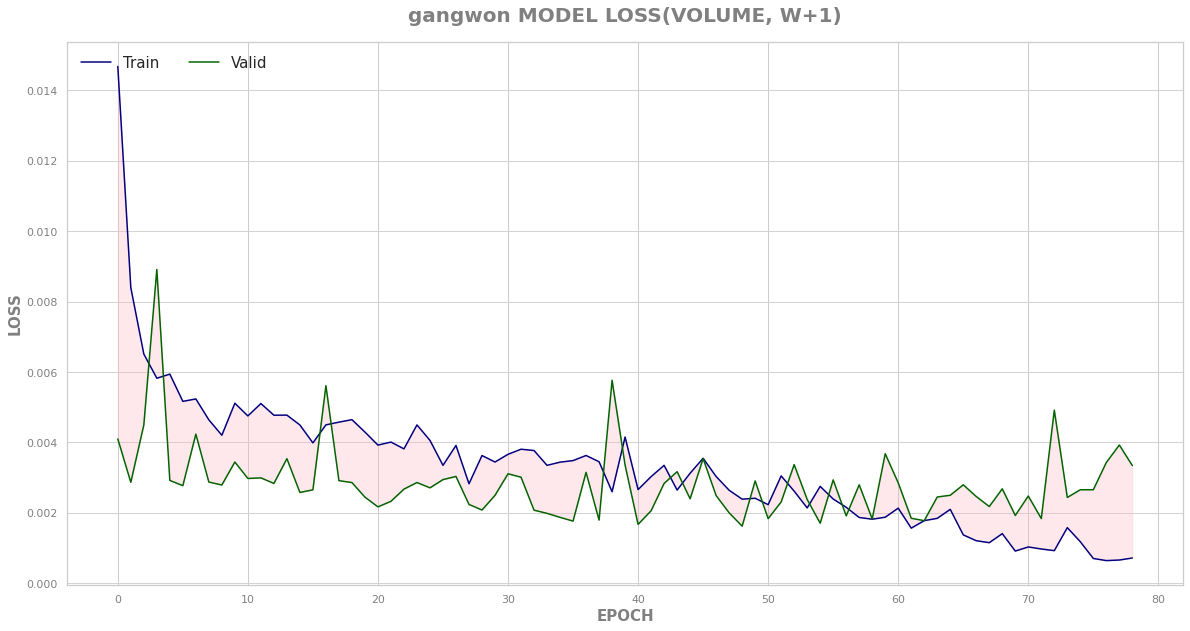

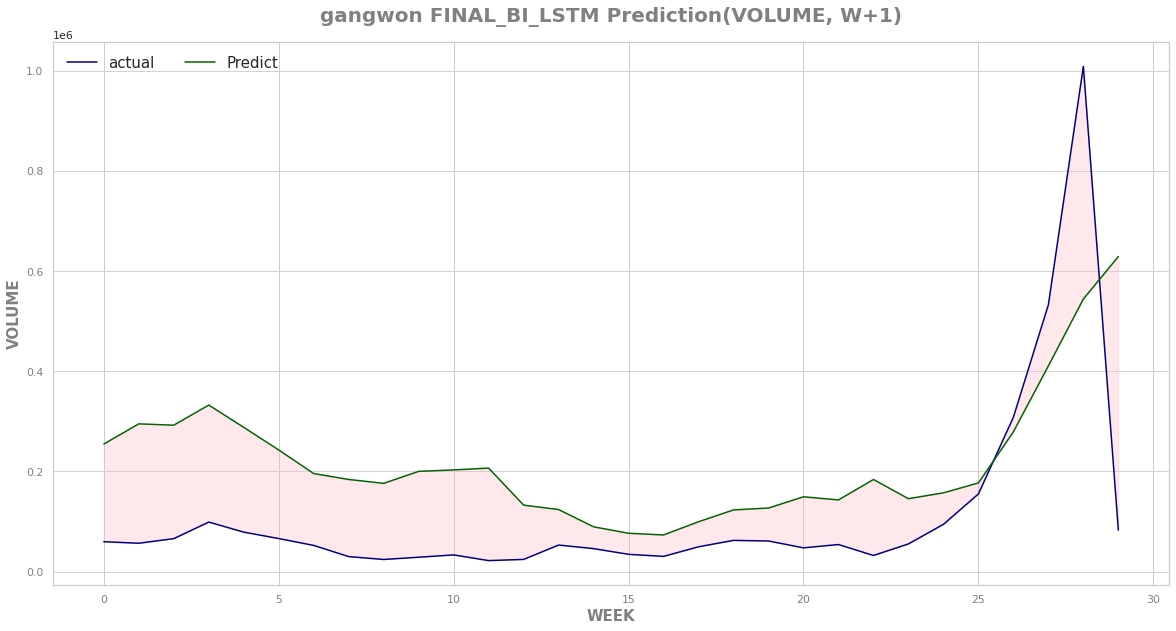

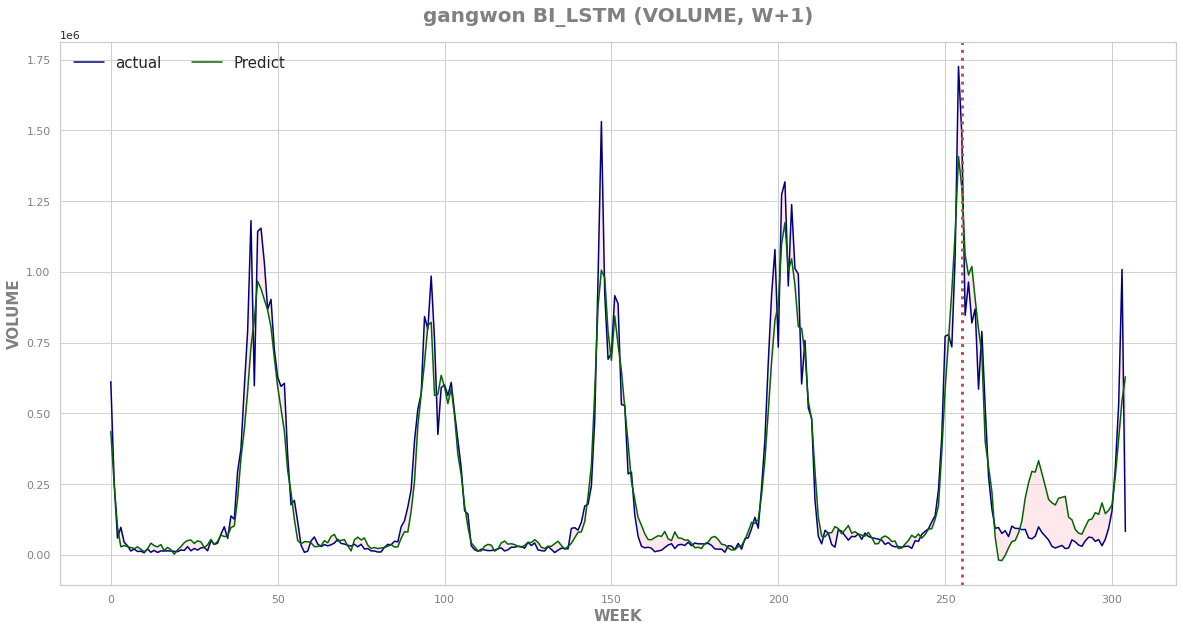

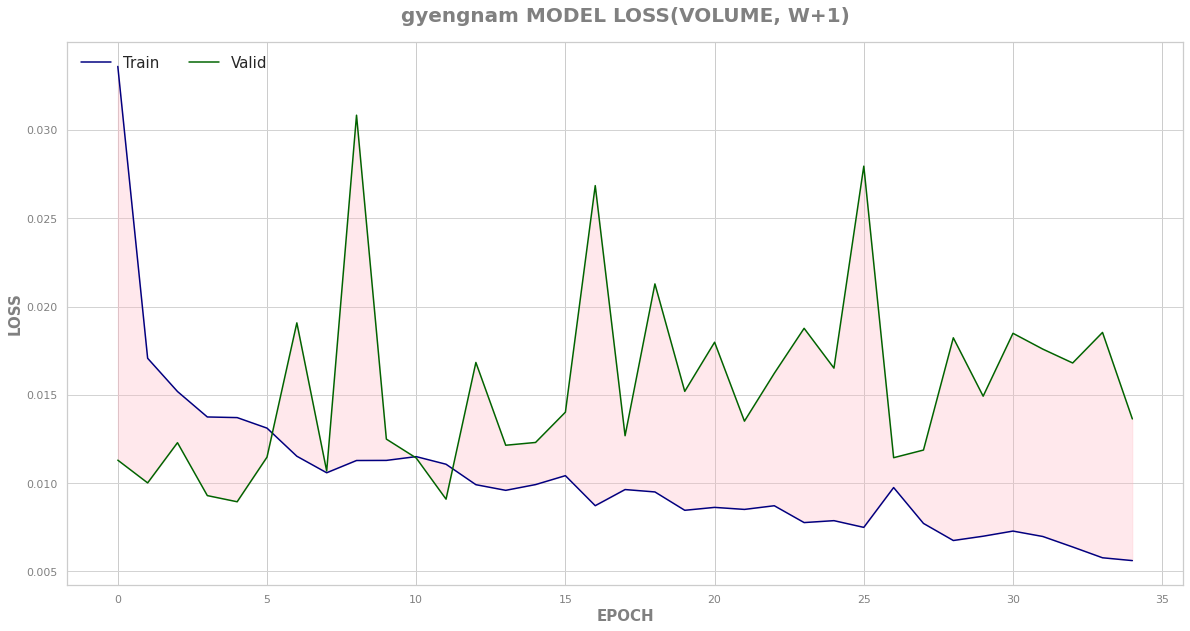

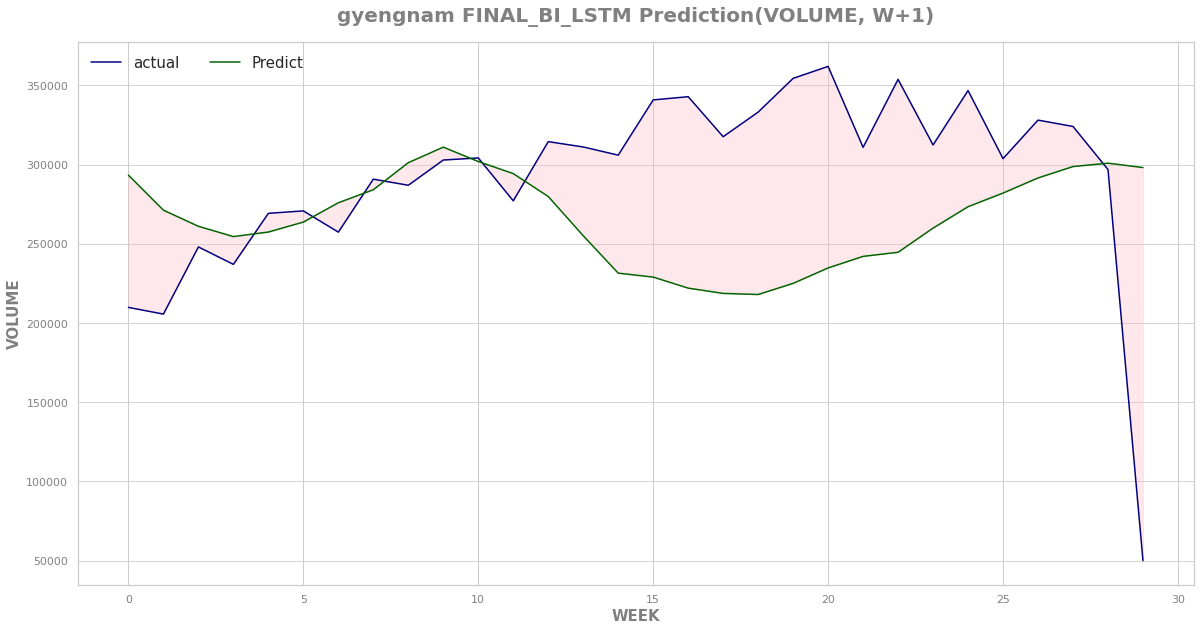

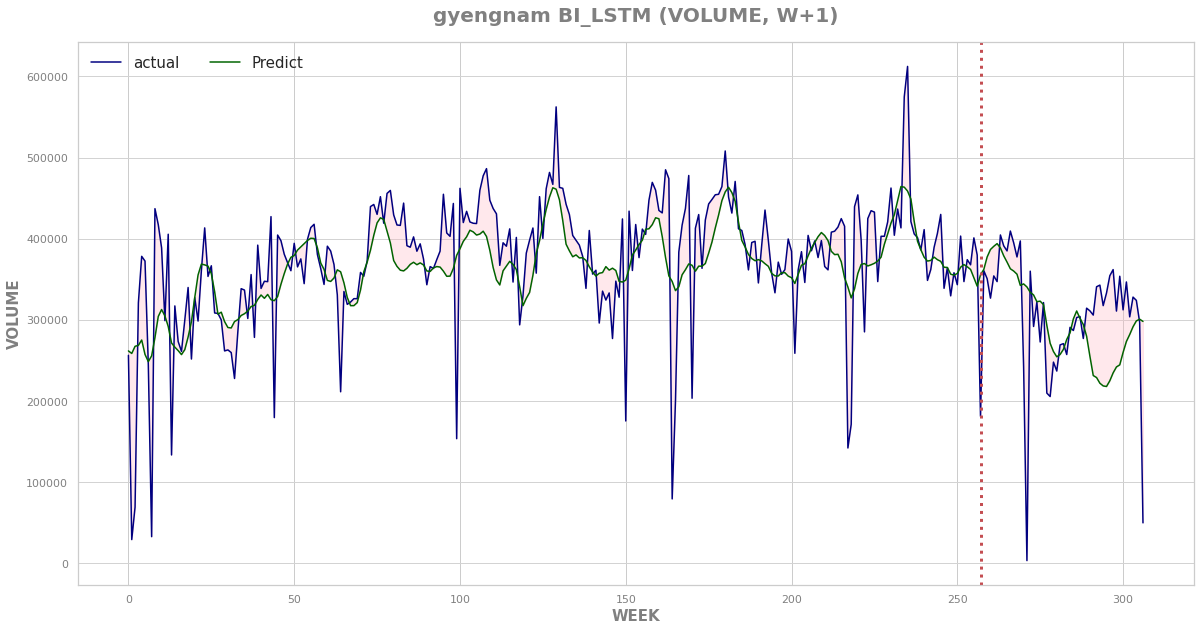

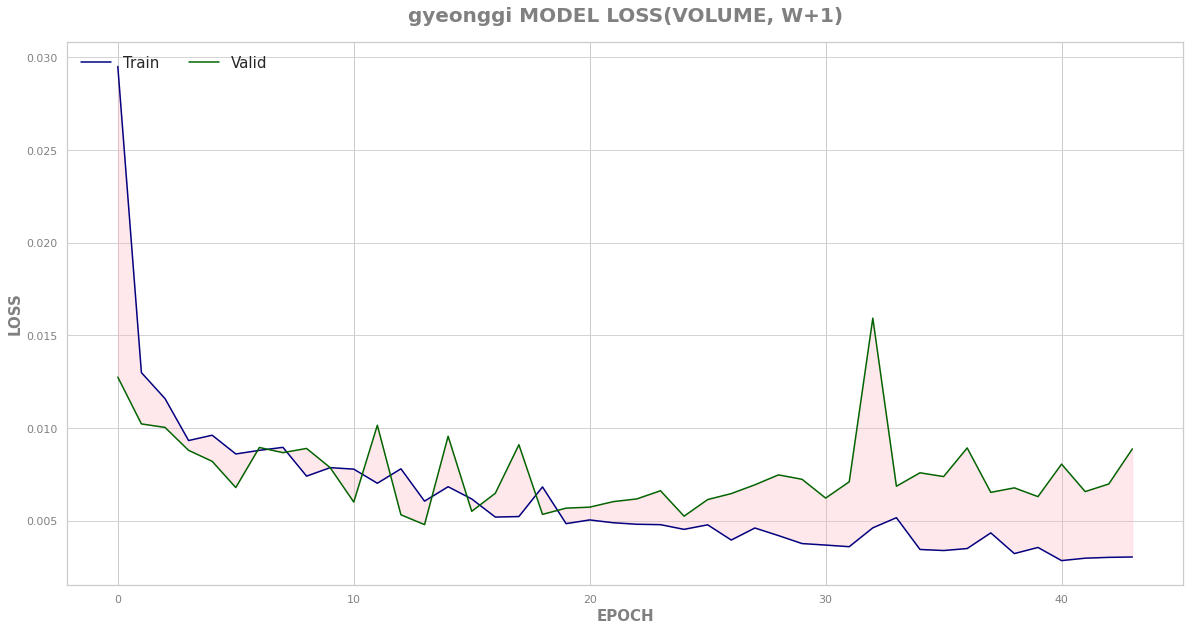

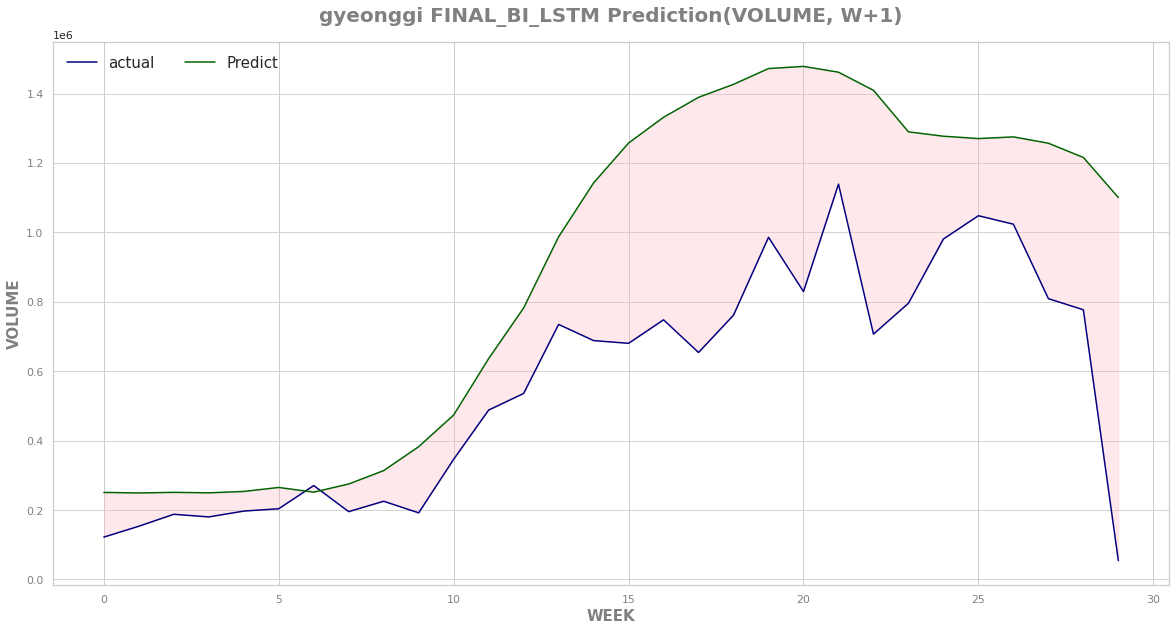

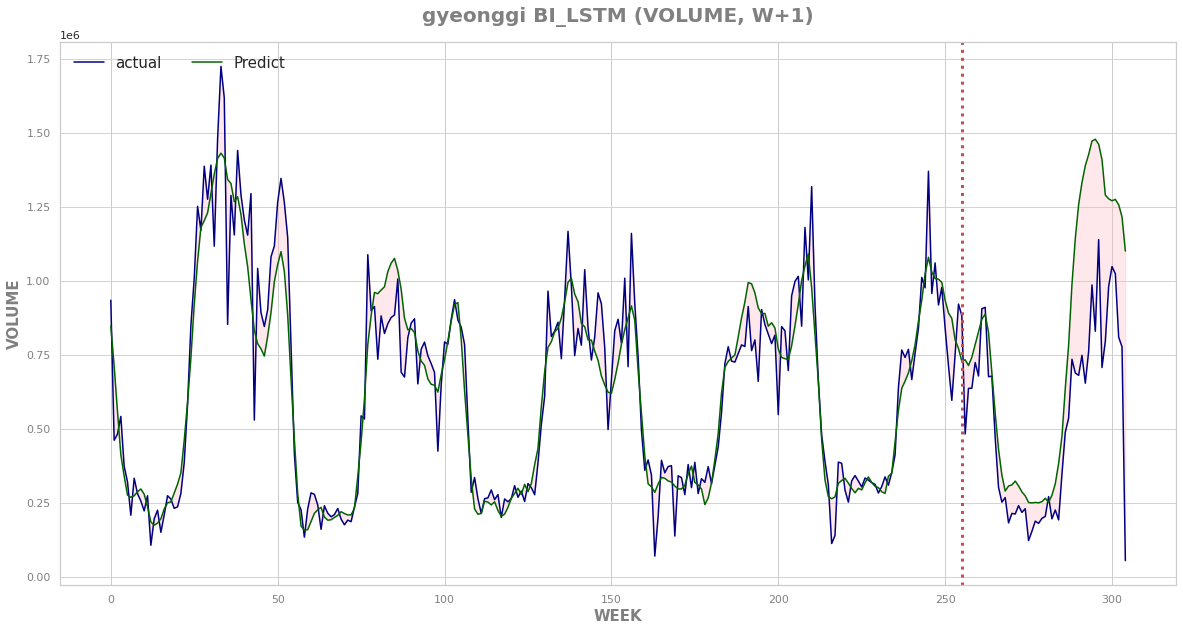

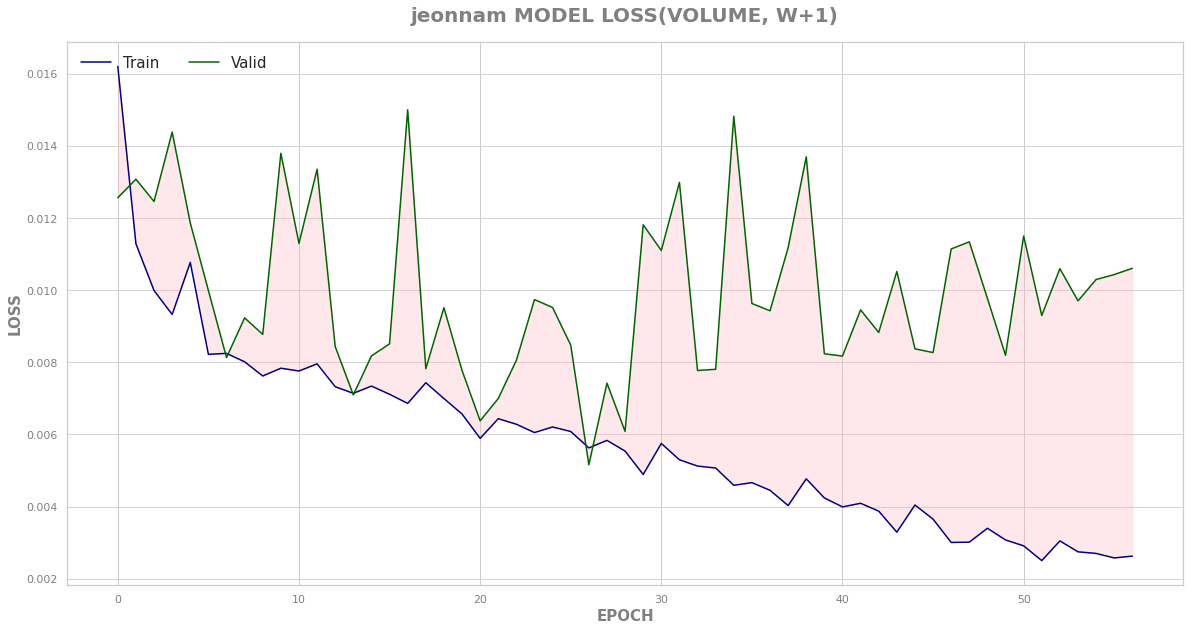

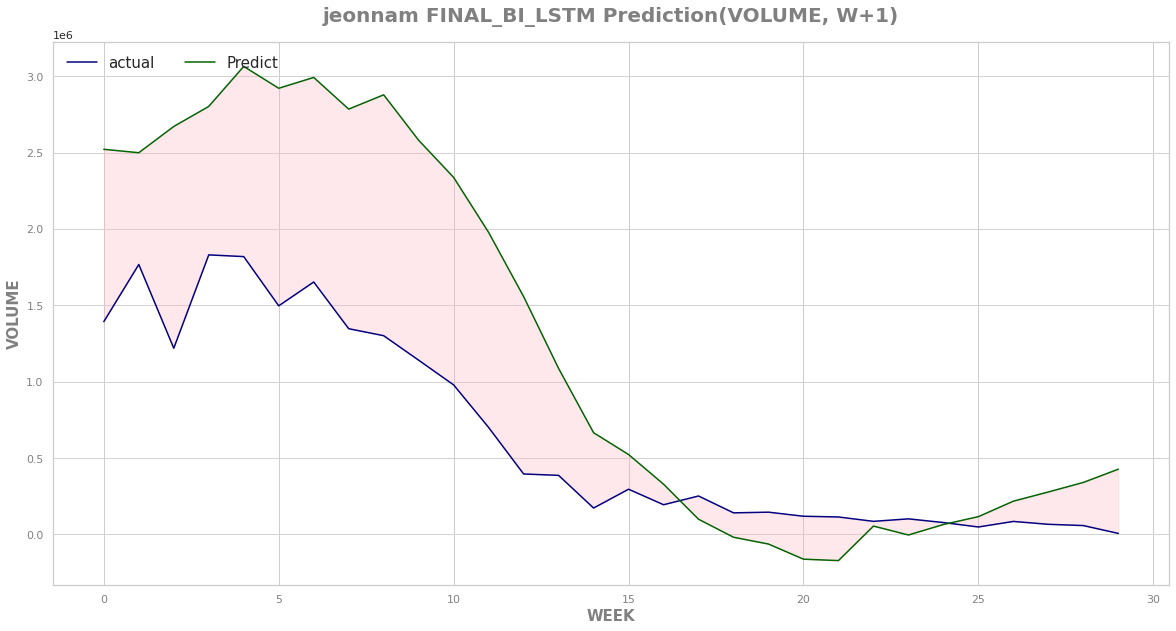

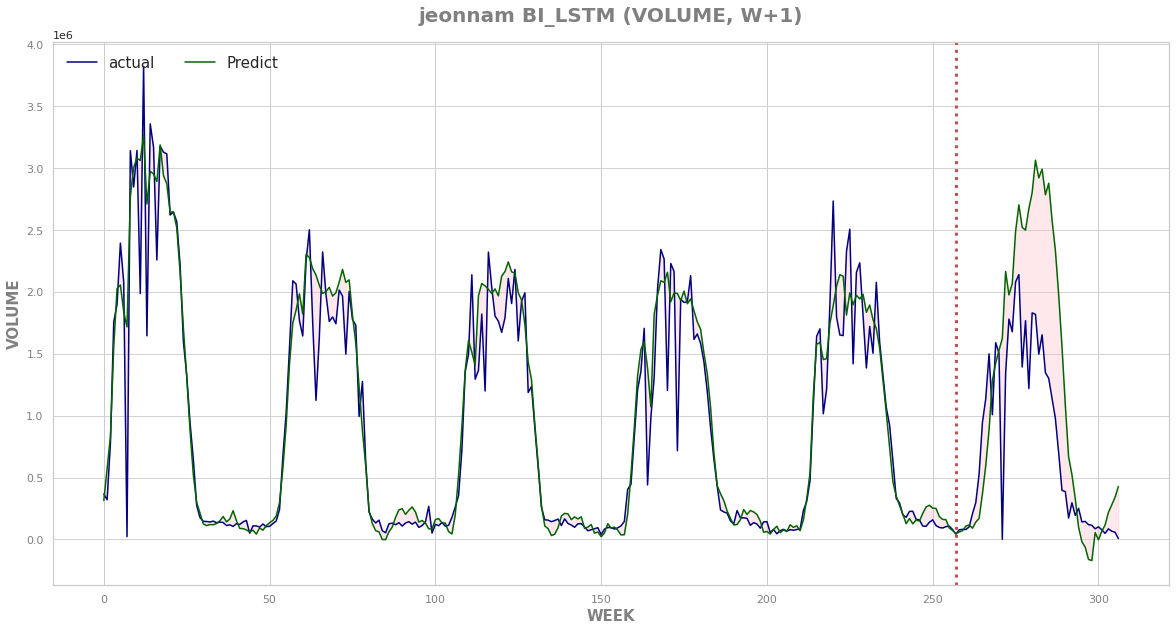

In [ ]:
hist_dict = {
    "gangwon": history_gangwon, 
    "gyengnam": history_gyengnam, 
    "gyeonggi": history_gyeonggi, 
    "jeonnam": history_jeonnam,
}

mms_y_dict = {
    "gangwon": gangwon_mmsclaer_y, 
    "gyengnam": gyengnam_mmsclaer_y, 
    "gyeonggi": gyeonggi_mmsclaer_y, 
    "jeonnam": jeonnam_mmsclaer_y,
}

model_dict = {
    "gangwon": model_gangwon, 
    "gyengnam": model_gyengnam, 
    "gyeonggi": model_gyeonggi, 
    "jeonnam": model_jeonnam,
}

path_dict = {
    "gangwon": path_gangwon, 
    "gyengnam": path_gyengnam, 
    "gyeonggi": path_gyeonggi, 
    "jeonnam": path_jeonnam,
}

res_dict = {
    "gangwon": res_gangwon, 
    "gyengnam": res_gyengnam, 
    "gyeonggi": res_gyeonggi, 
    "jeonnam": res_jeonnam,
}

scaled_dict = {
    "gangwon": gangwon_scaled, 
    "gyengnam": gyengnam_scaled, 
    "gyeonggi": gyeonggi_scaled, 
    "jeonnam": jeonnam_scaled,
}

train_dict = {
    "gangwon": train_gangwon, 
    "gyengnam": train_gyengnam, 
    "gyeonggi": train_gyeonggi, 
    "jeonnam": train_jeonnam,
}

x_dict = {
    "gangwon": test_x_gangwon, 
    "gyengnam": test_x_gyengnam, 
    "gyeonggi": test_x_gyeonggi, 
    "jeonnam": test_x_jeonnam,
}

y_dict = {
    "gangwon": test_y_gangwon, 
    "gyengnam": test_y_gyengnam, 
    "gyeonggi": test_y_gyeonggi, 
    "jeonnam": test_y_jeonnam,
}

for loc in LOCATION:
    # 모델 결과
    res_print(
        loc=loc,
        path=path_dict[loc],
        model=model_dict[loc],
        x=x_dict[loc],
        y=y_dict[loc],
        mms_y=mms_y_dict[loc],
        evaluate=res_dict[loc],
    )

    # 모델 loss
    graph_loss(
        loc=loc,
        history=hist_dict[loc],
    )

    # 예측 그래프
    graph_predict(
        loc=loc,
        model_path=f"{FOLDER_PATH}Model/{path_dict[loc]}.h5",
        model=model_dict[loc],
        x=x_dict[loc],
        y=y_dict[loc],
        mms_y=mms_y_dict[loc],
    )

    # 학습 그래프
    # graph_train(
    #     loc=loc,
    #     train_ds=train_dict[loc], 
    #     model_path=f"{FOLDER_PATH}[LSTM]{path_dict[loc]}.h5",
    #     model=model_dict[loc],
    #     mms_y=mms_y_dict[loc],
    # )

    # 학습 + 예측 그래프
    graph_finished(
        loc=loc,
        path=path_dict[loc],
        scaled_ds=scaled_dict[loc], 
        train_ds=train_dict[loc],
        model_path=f"{FOLDER_PATH}Model/{path_dict[loc]}.h5",
        model=model_dict[loc],
        mms_y=mms_y_dict[loc],
    )

In [ ]:
from sklearn.externals import joblib
from keras.models import load_model
import pickle

In [ ]:
model_gyeonggi.save('/content/drive/My Drive/Colab Notebooks/bimodel_gyeonggi.h5')
model_gyeonggi.save('/content/drive/My Drive/Colab Notebooks/bimodel_gyeonggi.h5')
model_gyengnam.save('/content/drive/My Drive/Colab Notebooks/bimodel_gyeongnam.h5')
model_jeonnam.save('/content/drive/My Drive/Colab Notebooks/bimodel_jeonnam.h5')